<a href="https://colab.research.google.com/github/AkvileM/Birds_kaggel/blob/main/Birds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Birds clasification project
In this project data is from Kaggel datasets "BIRDS 525 SPECIES- IMAGE CLASSIFICATION". This dataset includes 525 species of birds. There is  84635 training images, 2625 test images(5 images per species) and 2625 validation images(5 images per species. All images are 224 X 224 X 3 color images in jpg format. Data set includes a train set, test set and validation set. Each set contains 525 sub directories, one for each bird species. 

In this project is tested EfficienetNet model for images clasification.

## I Part
Importing package for downloading kaggek dataset and downloading data from kaggel

In [2]:
from google.colab import files

From my own kaggel prifile I generated API

In [3]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


Moving it to appropriate folder

In [4]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d gpiosenka/100-bird-species

100% 1.95G/1.96G [01:26<00:00, 25.2MB/s]
100% 1.96G/1.96G [01:26<00:00, 24.3MB/s]


In [6]:
!unzip 100-bird-species.zip

Srautinio perdavimo išvestis sutrumpinta iki kelių paskutinių eilučių (5000).
  inflating: train/WHITE TAILED TROPIC/120.jpg  
  inflating: train/WHITE TAILED TROPIC/121.jpg  
  inflating: train/WHITE TAILED TROPIC/122.jpg  
  inflating: train/WHITE TAILED TROPIC/123.jpg  
  inflating: train/WHITE TAILED TROPIC/124.jpg  
  inflating: train/WHITE TAILED TROPIC/125.jpg  
  inflating: train/WHITE TAILED TROPIC/126.jpg  
  inflating: train/WHITE TAILED TROPIC/127.jpg  
  inflating: train/WHITE TAILED TROPIC/128.jpg  
  inflating: train/WHITE TAILED TROPIC/129.jpg  
  inflating: train/WHITE TAILED TROPIC/130.jpg  
  inflating: train/WHITE TAILED TROPIC/131.jpg  
  inflating: train/WHITE TAILED TROPIC/132.jpg  
  inflating: train/WHITE TAILED TROPIC/133.jpg  
  inflating: train/WHITE TAILED TROPIC/134.jpg  
  inflating: train/WHITE TAILED TROPIC/135.jpg  
  inflating: train/WHITE TAILED TROPIC/136.jpg  
  inflating: train/WHITE TAILED TROPIC/137.jpg  
  inflating: train/WHITE TAILED TROPIC/1

## II part
Loading the needed packages for my data

In [7]:
# Import PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.utils.data as dset

# Import torchvision
import torchvision
from torchvision import datasets, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

# Import matplotlib for visualization and PIL for image processing
from PIL import Image
import matplotlib.pyplot as plt

#for time measuremes
import time 

#extracting data
import os
import copy
#for some computations
import numpy as np 

## III part
Setup device agnostic-code (for using a GPU if there is one). 
As this data set is quite big I purchased Colab pro to be sure that I will work with GPU

In [8]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("GPU State:", device)

GPU State: cuda:0


## IV part
### 1. Data transformation for each splitted dataset. For normalization there is used the same mean anmd standar deviation like in ImageNet dataset statistics.

In [9]:
inputSize = 224

transform = {
    "train": transforms.Compose([
        # Data Augmentation
        transforms.RandomResizedCrop(inputSize, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    "valid": transforms.Compose([
        transforms.Resize((inputSize, inputSize)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize((inputSize, inputSize)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

### 2. Initializings dataset by creating a dictionary named dataSets and of course intializing dataloader for each instancies od Dataset.




In [10]:
dataDir = "./"


dataSets = {x: datasets.ImageFolder(os.path.join(dataDir, x), transform[x]) for x in ["train", "valid", "test"]}
dataSets["train"] = dset.ConcatDataset([
    dataSets["train"],
    datasets.ImageFolder(os.path.join(dataDir, "train"), transform["test"]),
])


dataLoaders = {
    x: dset.DataLoader(dataSets[x], batch_size=64, shuffle=True, num_workers=12)
    for x in ["train", "valid", "test"]
}

### 3. Other parameters which will be used later in the functions

In [11]:

datasetSizes = {x: len(dataSets[x]) for x in ["train", "valid", "test"]}
classNames = dataSets['test'].classes
classNames = [string.title() for string in classNames]

### 4. Now lets plot some images from train dataset

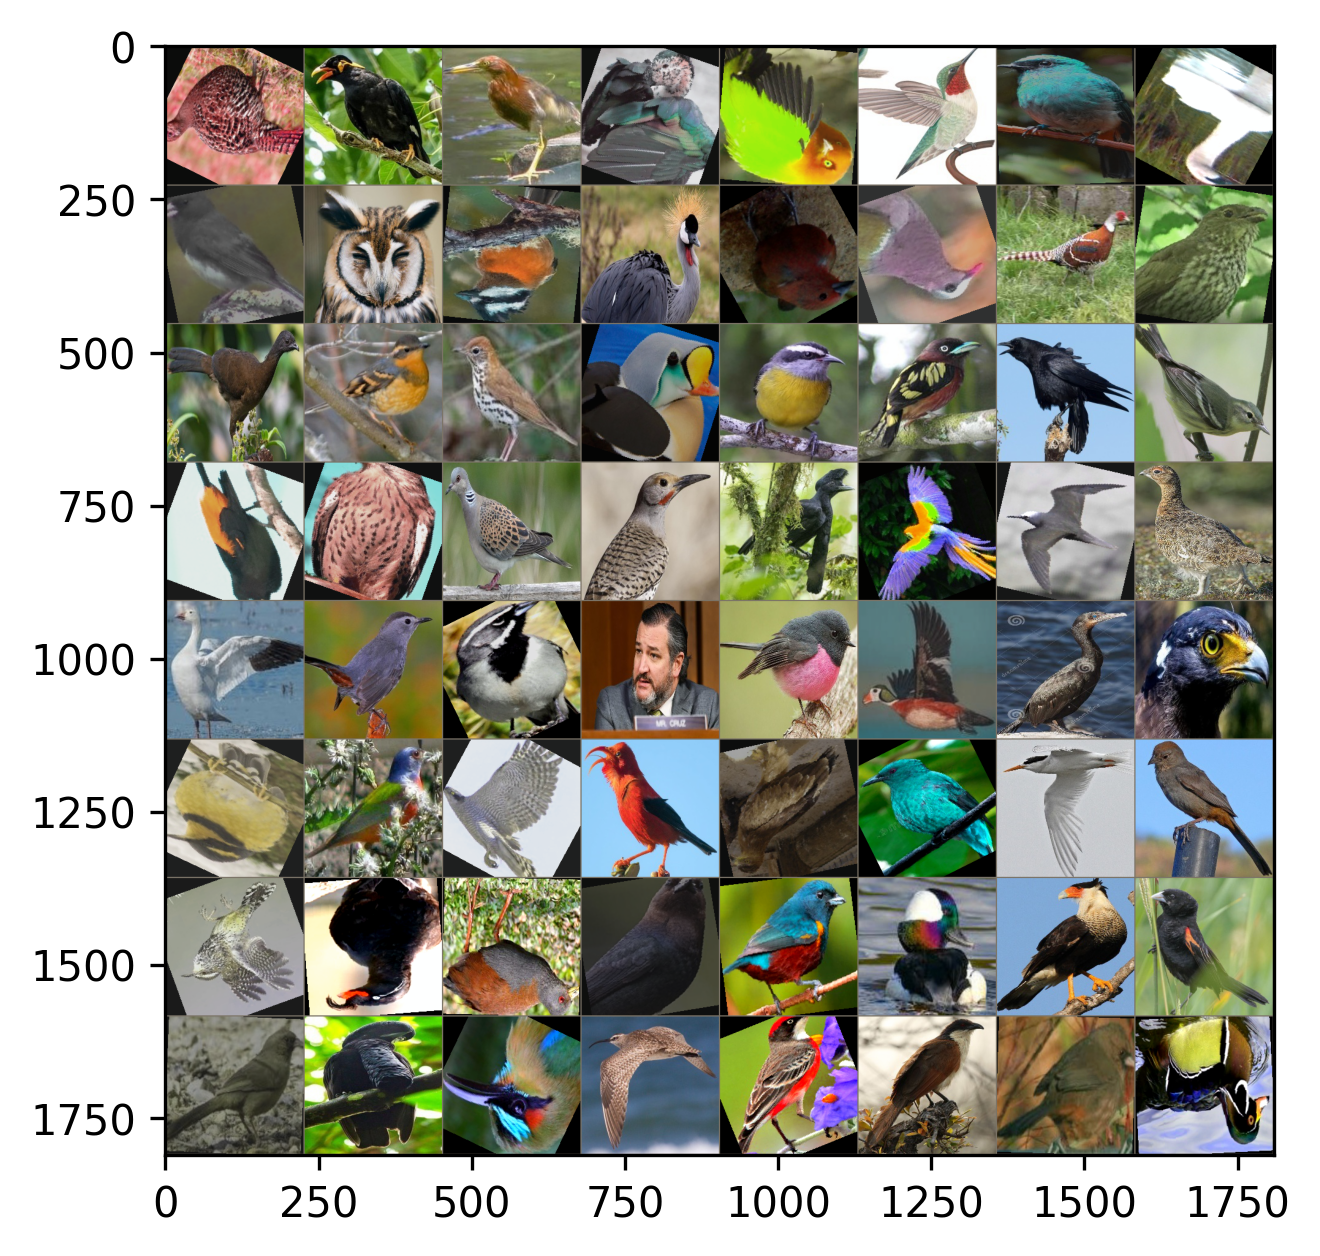

In [12]:
plt.rcParams['figure.dpi'] = 300
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataLoaders["train"]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

## V part model creation

### 1. firstly it will be created 2 functions (train the model and visualize the model

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time() # initializes variables
    # stores best ACC
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    graph_accs = [[], []]
    graph_loss = [[], []]

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 50)

        # Epoch and phase iteration  over two phases
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterating over data
            for times, (inputs, labels) in enumerate(dataLoaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                # Print running statistics.
                if times % 100 == 99 or times + 1 == len(dataLoaders[phase]):
                    train_epoch_loss = running_loss / len(dataLoaders[phase].dataset)
                    train_epoch_acc = running_corrects / len(dataLoaders[phase].dataset)
                    print(
                        f'[{epoch}/{num_epochs - 1}, {times + 1}/{len(dataLoaders[phase])}] loss: {train_epoch_loss:.3f} acc: {train_epoch_acc:.3f}')

            epoch_loss = running_loss / datasetSizes[phase]
            epoch_acc = running_corrects.double() / datasetSizes[phase]

            if phase == 'train':
                scheduler.step()

            graph_accs[0 if phase == 'train' else 1].append(epoch_acc)
            graph_loss[0 if phase == 'train' else 1].append(epoch_loss)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Plot the graph to show the accuracy, and loss.
    plt.figure(figsize=(10, 5))
    plt.title("Accuracy and Loss")
    plt.plot(torch.tensor(graph_accs[0]).cpu(), label="train acc", color="blue")
    plt.plot(torch.tensor(graph_accs[1]).cpu(), label="valid acc", color="red")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left')

    plt.twinx()
    plt.plot(torch.tensor(graph_loss[0]).cpu(), label="train loss", color="dodgerblue")
    plt.plot(torch.tensor(graph_loss[1]).cpu(), label="valid loss", color="tomato")
    plt.ylabel("Loss")
    plt.legend(bbox_to_anchor=(1.1, 0.8), loc='upper left')
    plt.show()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### 2. Model visualisation for some images

In [14]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataLoaders["test"]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis("off")
                ax.set_title(f'predicted: {classNames[preds[j]]} {preds[j] == labels[j]}', fontsize=6)
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return

        model.train(mode=was_training)

### 3. EFFICIENTNET with b0 weights from preprained Imagene1k_v1, which was given in kaggel data set initialisation.

Also  creating forward pass of the model layers and  unfreezing layers to be updating during training

In [15]:
# Model
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layers = efficientnet_b0(
            weights=EfficientNet_B0_Weights.IMAGENET1K_V1
        )
        # Freeze the model here so that only the EfficientNet layers are frozen.
        self.freeze()

        self.layers.classifier[1] = nn.Sequential(
            nn.Linear(1280, 525),
            nn.LogSoftmax(1)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

    def freeze(self):
        for param in self.layers.parameters():
            param.requires_grad = False

    def unfreeze(self):
        for param in self.layers.parameters():
            param.requires_grad = True


model = Model().to(device)
print(model)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 98.6MB/s]


Model(
  (layers): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activati

### 4. parameters for function

In [16]:
# Parameters and Functions
trainEpochs = 10
fineturnEpochs = 35

# Loss Function
criterion = nn.NLLLoss()

# Optimizer. It will update trainable parameters during taining with weight decay regularization
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# learning rate scheduler
lrScheduler1 = lr_scheduler.ExponentialLR(optimizer, gamma=0.95, verbose=False)
lrScheduler2 = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, verbose=True)

Epoch 00000: adjusting learning rate of group 0 to 1.0000e-03.


### 5. Running the model

Epoch 0/9
--------------------------------------------------
[0/9, 100/2645] loss: 0.219 acc: 0.004
[0/9, 200/2645] loss: 0.388 acc: 0.015
[0/9, 300/2645] loss: 0.527 acc: 0.031
[0/9, 400/2645] loss: 0.647 acc: 0.049
[0/9, 500/2645] loss: 0.752 acc: 0.069
[0/9, 600/2645] loss: 0.849 acc: 0.090
[0/9, 700/2645] loss: 0.939 acc: 0.111
[0/9, 800/2645] loss: 1.024 acc: 0.133
[0/9, 900/2645] loss: 1.103 acc: 0.156
[0/9, 1000/2645] loss: 1.178 acc: 0.179
[0/9, 1100/2645] loss: 1.252 acc: 0.203
[0/9, 1200/2645] loss: 1.324 acc: 0.226
[0/9, 1300/2645] loss: 1.392 acc: 0.250
[0/9, 1400/2645] loss: 1.460 acc: 0.274
[0/9, 1500/2645] loss: 1.525 acc: 0.298
[0/9, 1600/2645] loss: 1.590 acc: 0.323
[0/9, 1700/2645] loss: 1.653 acc: 0.347
[0/9, 1800/2645] loss: 1.715 acc: 0.372
[0/9, 1900/2645] loss: 1.777 acc: 0.397
[0/9, 2000/2645] loss: 1.839 acc: 0.421
[0/9, 2100/2645] loss: 1.898 acc: 0.447
[0/9, 2200/2645] loss: 1.956 acc: 0.472
[0/9, 2300/2645] loss: 2.014 acc: 0.497
[0/9, 2400/2645] loss: 2.071

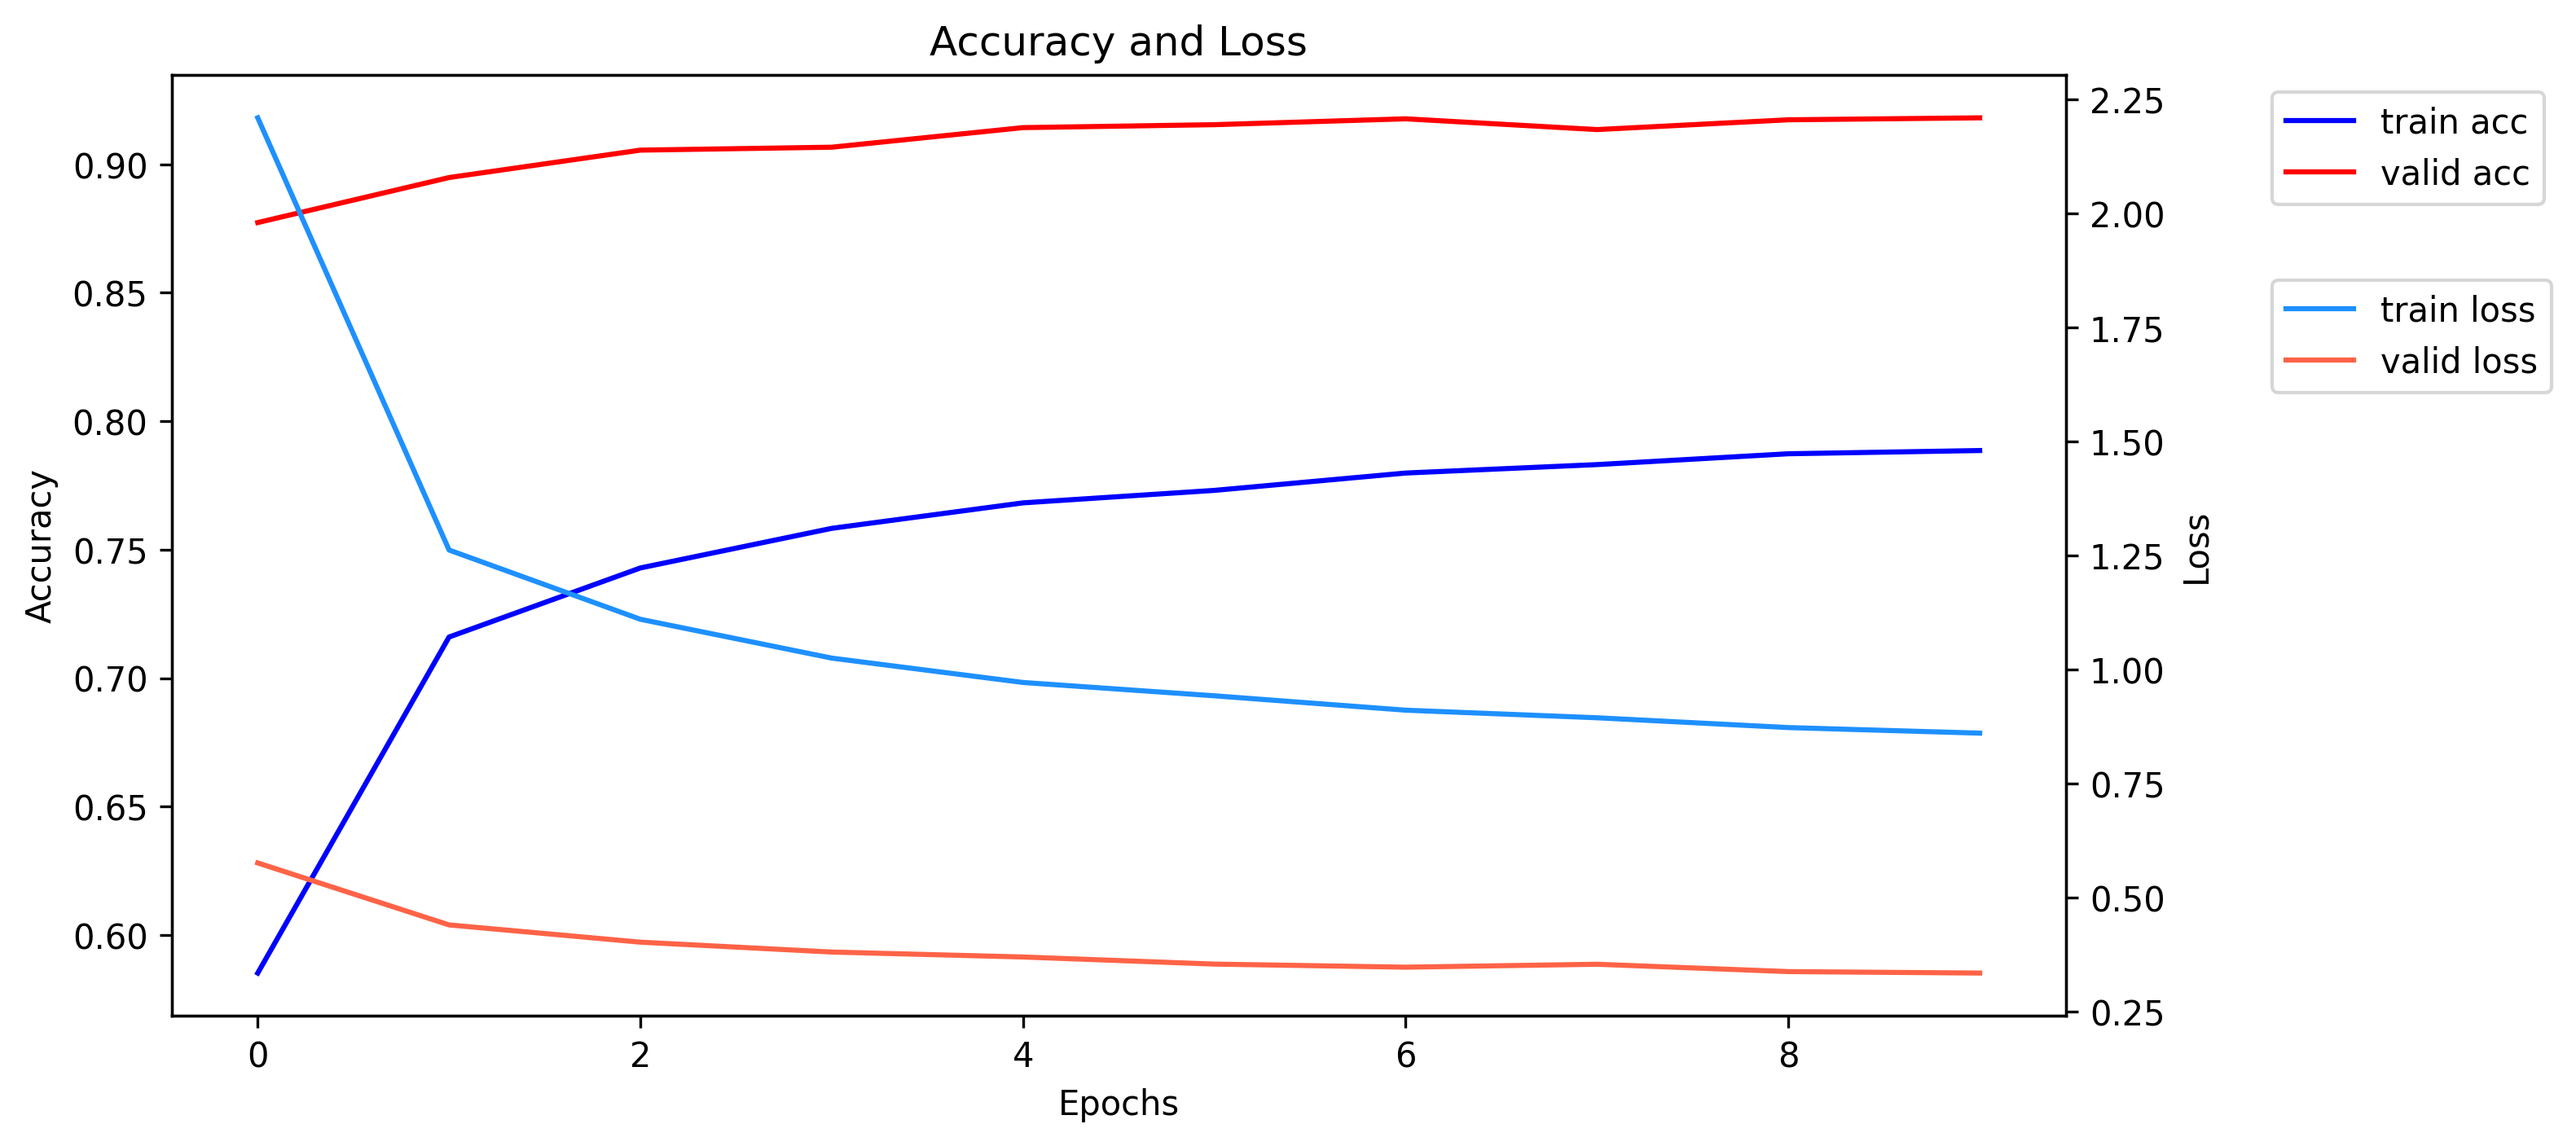

In [17]:
model = train_model(model, criterion, optimizer, lrScheduler1, num_epochs=trainEpochs)

This model gets very good results as validation loss is quite small and accuracy is quite high. But lets try to get better results

Epoch 0/34
--------------------------------------------------
[0/34, 100/2645] loss: 0.025 acc: 0.031
[0/34, 200/2645] loss: 0.045 acc: 0.063
[0/34, 300/2645] loss: 0.064 acc: 0.096
[0/34, 400/2645] loss: 0.082 acc: 0.129
[0/34, 500/2645] loss: 0.099 acc: 0.162
[0/34, 600/2645] loss: 0.115 acc: 0.196
[0/34, 700/2645] loss: 0.130 acc: 0.229
[0/34, 800/2645] loss: 0.145 acc: 0.263
[0/34, 900/2645] loss: 0.160 acc: 0.297
[0/34, 1000/2645] loss: 0.174 acc: 0.331
[0/34, 1100/2645] loss: 0.189 acc: 0.365
[0/34, 1200/2645] loss: 0.203 acc: 0.399
[0/34, 1300/2645] loss: 0.216 acc: 0.433
[0/34, 1400/2645] loss: 0.230 acc: 0.467
[0/34, 1500/2645] loss: 0.242 acc: 0.502
[0/34, 1600/2645] loss: 0.254 acc: 0.536
[0/34, 1700/2645] loss: 0.267 acc: 0.571
[0/34, 1800/2645] loss: 0.278 acc: 0.605
[0/34, 1900/2645] loss: 0.290 acc: 0.640
[0/34, 2000/2645] loss: 0.301 acc: 0.675
[0/34, 2100/2645] loss: 0.313 acc: 0.709
[0/34, 2200/2645] loss: 0.323 acc: 0.744
[0/34, 2300/2645] loss: 0.334 acc: 0.779
[0/3

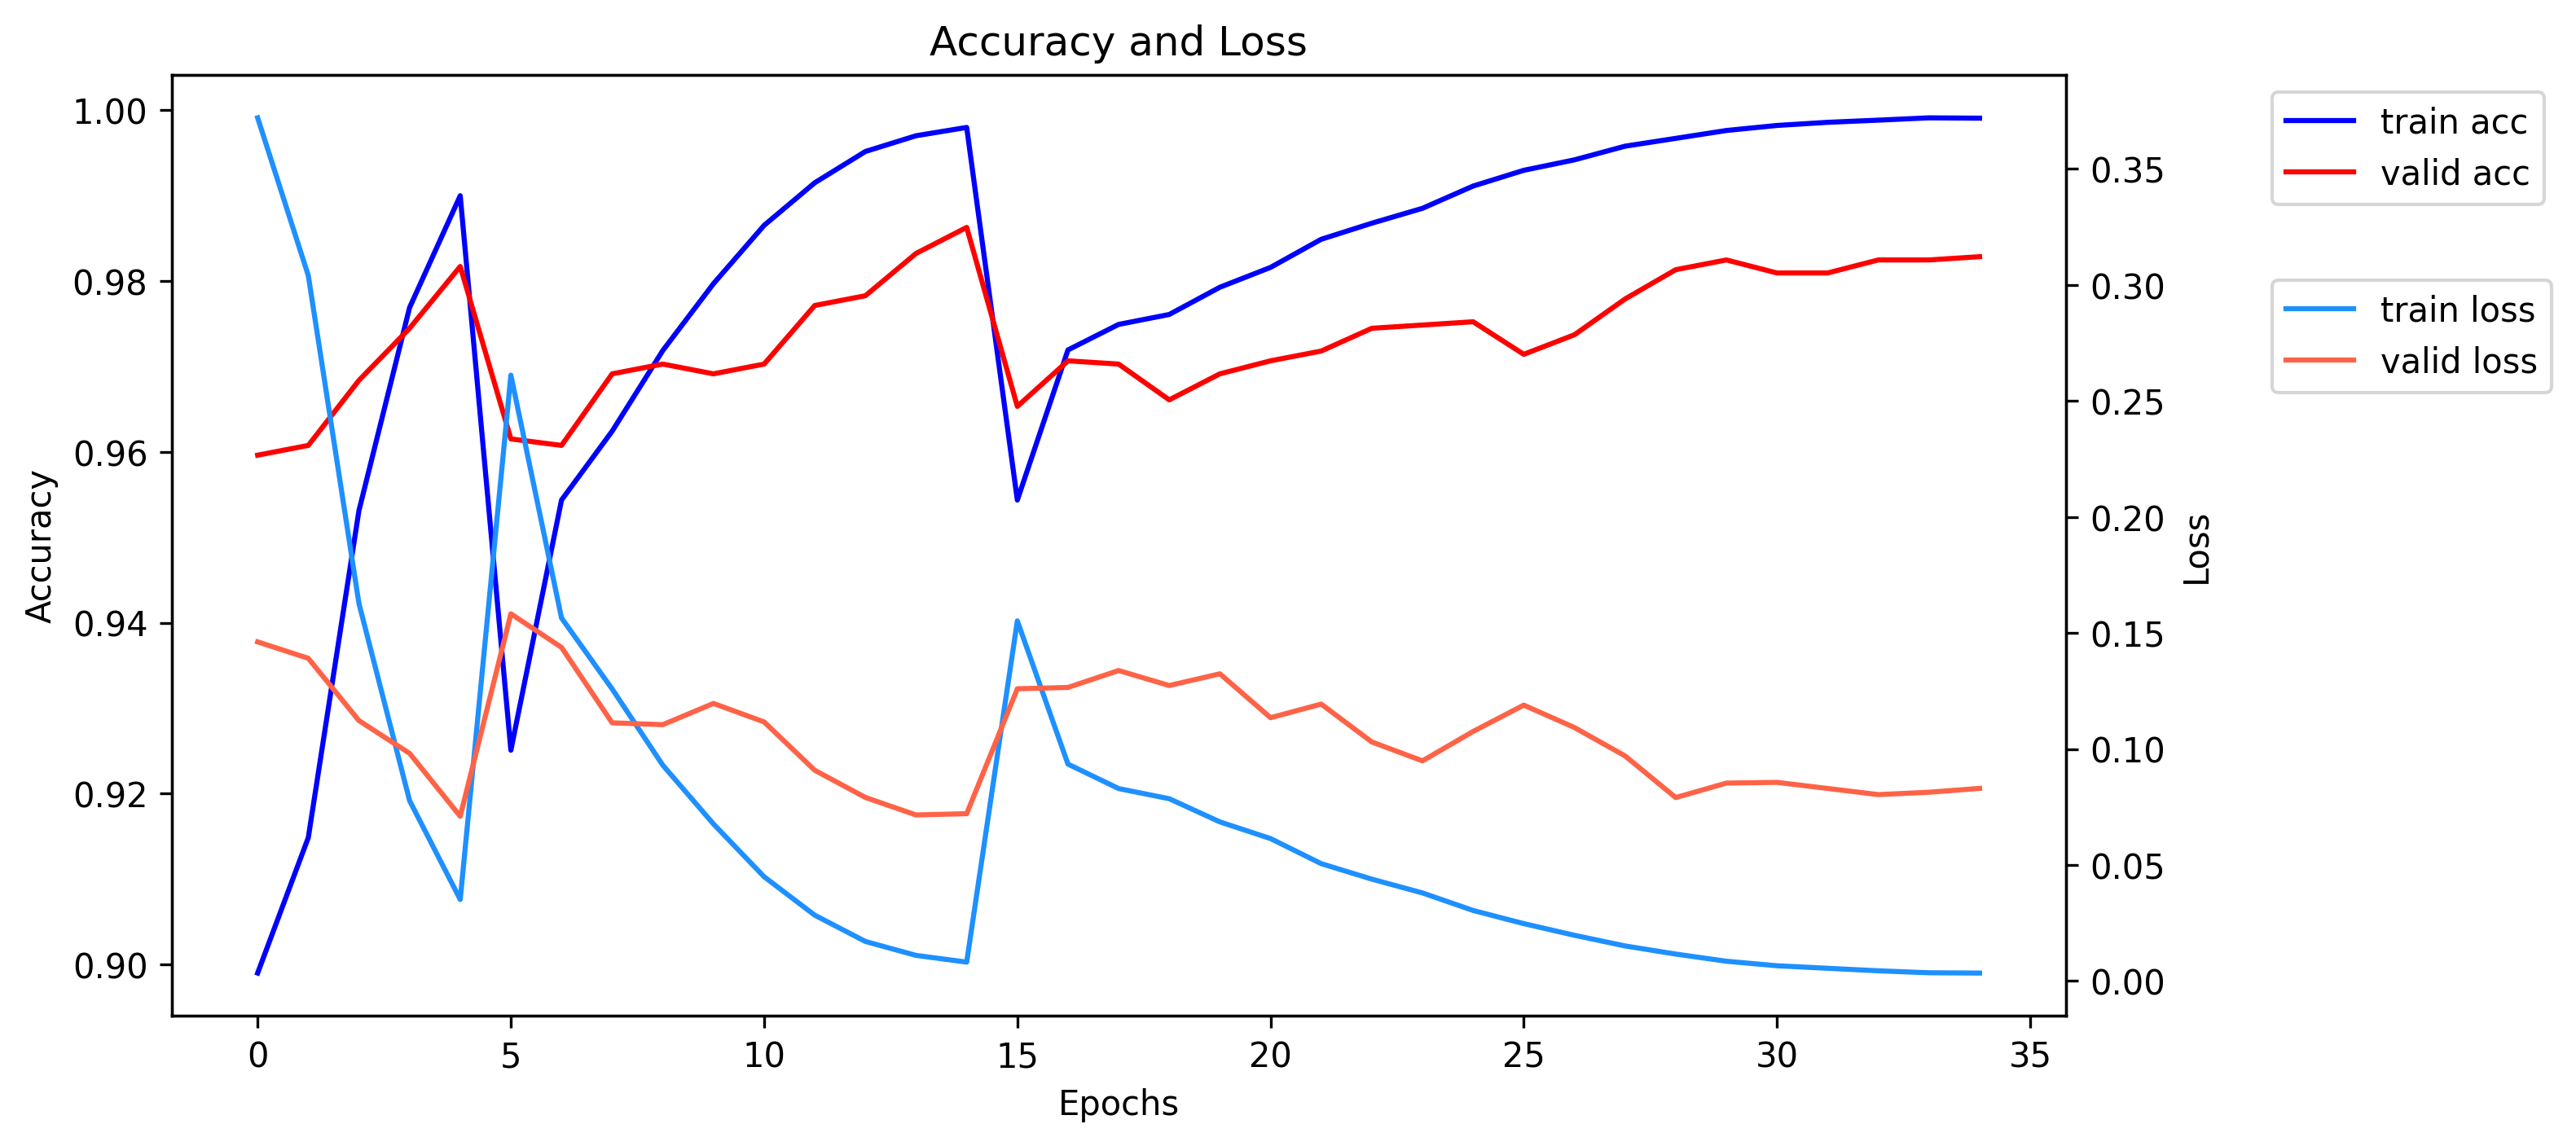

In [18]:
model.unfreeze()
model = train_model(model, criterion, optimizer, lrScheduler2, num_epochs=fineturnEpochs)

Updated model generated better results from both terms accuracy and validation loass.

### 6. saving the model

In [19]:
torch.save(model, "model.pt")

model_scripted = torch.jit.script(model)
model_scripted.save("model_scripted.pt")

### 7. Loading the saved model loading some images to see the model accuracy

In [20]:

model = torch.load("model.pt", map_location=device).to(device)
model.eval()

Model(
  (layers): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activati

### 8. Testing the model on test dataset

In [21]:
# Print the correctness of all.
correct = 0
total = 0

# Print the correctness of each class.
class_correct = [0 for i in range(525)]
class_total = [0 for i in range(525)]

model.eval()

with torch.no_grad():
    for datas in dataLoaders['test']:
        inputs, labels = datas
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            if len(labels) == 1:
                class_correct[label] += c
            else:
                class_correct[label] += c[i]
            class_total[label] += 1

# Print correctness.
print("Accuracy : %.2f %%" % (100 * correct / total))

# Print the correctness of each class.
# for i in range(525):
#     print("Accuracy of %d: %3f" % (i, (class_correct[i] / class_total[i])))

Accuracy : 99.28 %


### 9. Model visualization

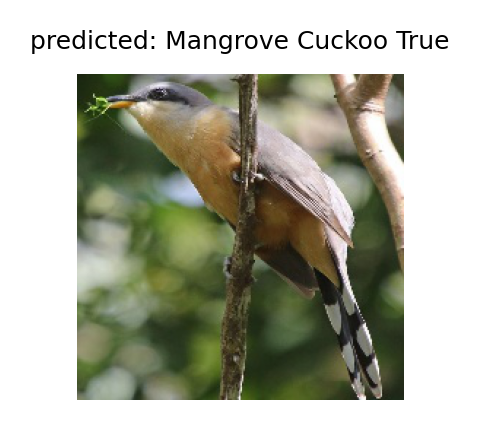

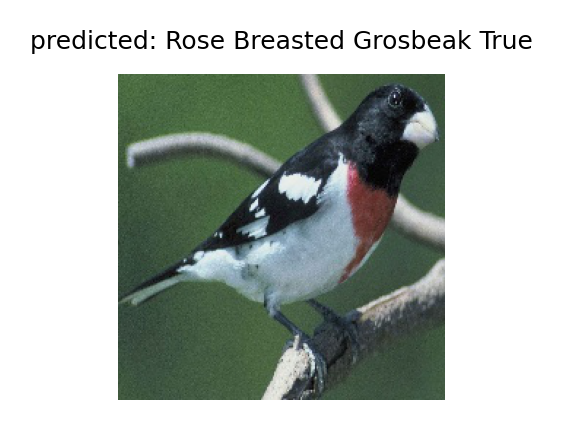

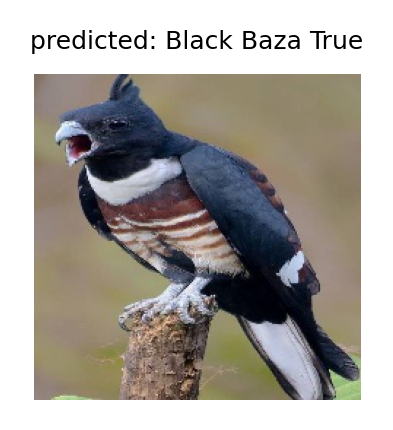

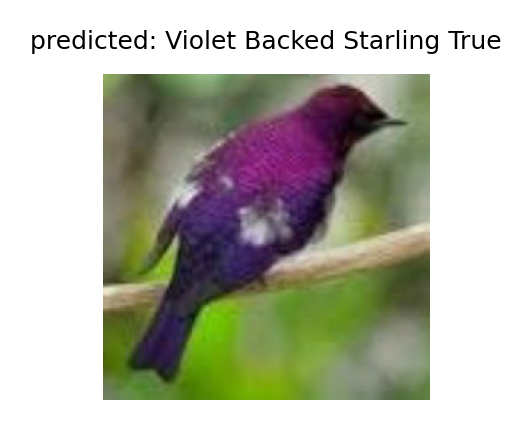

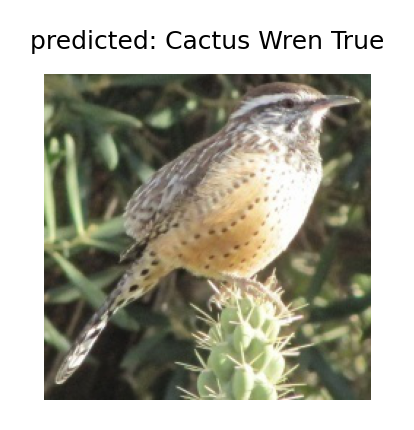

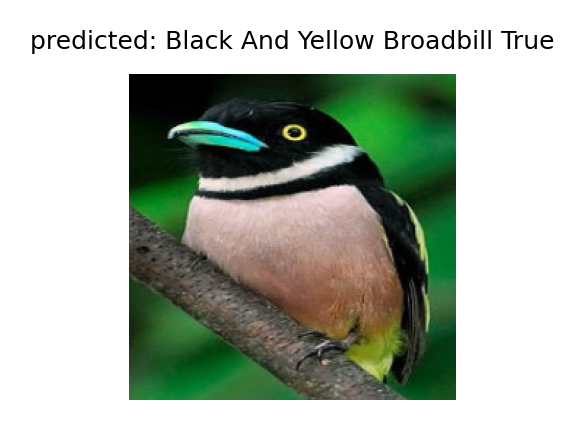

In [22]:
# Show some examples.
visualize_model(model)
plt.ioff()
plt.show()